# Komentáře


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import re

In [2]:
komm = pd.read_csv("komentare.csv", sep='\t')
#komm

/tmp/ipykernel_168/1648388463.py:1: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  komm = pd.read_csv("komentare.csv", sep='\t')


## Jaké je rozložení délky komentáře - na počet znaků (nastudovat, co je to histogram) 

In [21]:
cont = komm["content"]
cont.apply(str).apply(len)

0           97
1          308
2          307
3          346
4           35
          ... 
1422715     10
1422716     69
1422717     47
1422718    184
1422719     59
Name: content, Length: 1422720, dtype: int64

## Histogram dne. V kterém časovém období dne píšou lidé nejvíc komentáře?

In [39]:
%%time
histo = komm['created_date'].dropna()
histo = histo.apply(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").hour)


CPU times: user 13.4 s, sys: 95.7 ms, total: 13.5 s
Wall time: 13.5 s


In [41]:
%%time
histo = komm['created_date'].dropna()
## bez pretypovani je to znatelne rychlejsi
histo = histo.apply(lambda x: str(x)[str(x).index(' '):str(x).index(' ')+2:1])

CPU times: user 947 ms, sys: 85.3 ms, total: 1.03 s
Wall time: 1.03 s


<AxesSubplot:ylabel='Frequency'>

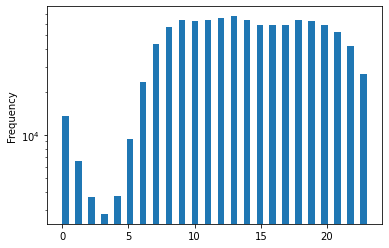

In [85]:
# 24 * 2 - 1 = 47
# pocet mezer je o 1 min nez pocet sloupcu
histo.plot.hist(bins=47, logy=True)

## Jaký je poměr komentářů na první (level=0) a druhé úrovni (level=1)

### Řešení č.1 
- je znatelně rychlejší než regex ale o to je hůř čitelnější

In [3]:
%%time

def tint(x):
    try:
        return int(x)
    except ValueError:
        return -1



l = komm['level']
c1 = 0
c2 = 0
#hodne trapne reseni
for index, value in l.items():
    if tint(value) == 0:
        c1+=1
    elif tint(value) == 1:
        c2+=1

d = math.gcd(c1, c2)  
#print(d)
c1 = int(c1 / d);
c2 = int(c2 / d);
print(f"POMER uroven1:uroven2 {c1}:{c2}")
print( c1/c2)

POMER uroven1:uroven2 424129:707428
0.599536631289686
CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.13 s


### Řešení č.2
- Využití Regexu

In [43]:
%%time
ll = komm.set_index('level')["user_id"]

l1 = ll.filter(regex=r"^0")
l2 = ll.filter(regex=r"^1")

c1 = l1.count()
c2 = l2.count()

d = math.gcd(c1,c2)

print(f"POMER uroven1:uroven2 {int(c1/d)}:{int(c2/d)}")

POMER uroven1:uroven2 424129:707428
CPU times: user 4.07 s, sys: 262 ms, total: 4.33 s
Wall time: 4.32 s


## Kolik unikátních uživatelů napsalo minulý měsíc komentář?

In [47]:
%%time
today = datetime.date.today()
first = today.replace(day=1)
lastMonth = first - datetime.timedelta(days=1)
yearMonth = lastMonth.strftime("%Y-%m")

last_m = komm.set_index("user_id")["created_date"].dropna()
last_m = last_m.apply(lambda x: str(x)[0:7:1])
reverse = pd.Series(data=last_m.index,index=last_m.values)
reverse.filter(like=yearMonth).drop_duplicates().count()


CPU times: user 1.46 s, sys: 164 ms, total: 1.62 s
Wall time: 1.64 s


70744

## Vypsat prvních 100 nejaktivnějších přispěvatelů.

In [7]:
poleUid = pd.Series(komm.dropna()["user_id"].values)
poleUid.value_counts().head(100).index.tolist()

['1076207',
 '110669851',
 '777223',
 '29255935',
 '15911976',
 '8305572',
 '15200198',
 '9766466',
 '21226504',
 '3091490',
 '7314619',
 '33778487',
 '25862381',
 '27491091',
 '94194026',
 '111227721',
 '9274686',
 '96041897',
 '31535430',
 '109873414',
 '10925447',
 '6691805',
 '12249702',
 '2971285',
 '123606051',
 '102400715',
 '2323135',
 '102790395',
 '6635944',
 '105055592',
 '69408498',
 '19050120',
 '4190557',
 '106685308',
 '96007007',
 '35815564',
 '32434969',
 '63337511',
 '498810',
 '41182835',
 '155883',
 '8845554',
 '6453565',
 '10945340',
 '9238387',
 '20395836',
 '1243315',
 '123512700',
 '17033079',
 '13725160',
 '42991533',
 '8712398',
 '101507519',
 '16420933',
 '13020447',
 '31222131',
 '1035946',
 '92112342',
 '109399360',
 '91228238',
 '5343455',
 '111139861',
 '59902640',
 '126744710',
 '123920360',
 '2801510',
 '11790696',
 '16755127',
 '108948380',
 '104966156',
 '150578',
 '125731119',
 '65104233',
 '13283053',
 '25906314',
 '9664516',
 '109979789',
 '8124766

## Výzva z pokročilejších algoritmů: Pomocí algoritmu tf-idf extrahovat nejrelevantnější/nejvýznamnější slova z každého komentáře.

### Řešení č.1


#### Časy:
- Prvních 20 bez předpřipravených dat  7min 36s
- Prvních 20 s daty logarytmů 1.4s
- Prvních 100 s daty 20. 19min 23s
- 100 se všemi daty 1.62s
- 100 s polovinou dat 13min 46s


In [80]:
logy = pd.Series(dtype = int)
commenty = komm.dropna().set_index("content")["user_id"]
count = commenty.count()
i = 1

In [74]:
i = 1

#### Získat list všech slov

In [79]:
def UnikatniSlova(veta):
    uslova = []
    for slovo in veta:
        if slovo not in uslova:
            uslova.append(slovo)
    return uslova

#### TF-IDF

In [78]:
def TfIdf(comment, word, logcount):
    n = comment.count(word) / len(comment)
    return n * logcount

def TfIdfbest5(comment):
    global i
    print(i, end=" ")
    i += 1
    unique = pd.Series(index = UnikatniSlova(comment), dtype=int)
    for slovo in unique.index:
        if slovo == '':
            continue
        if logy.get(slovo, default = 0) == 0:
            logy.at[slovo] = math.log10(count / commenty.filter(like=slovo).count())
        unique.at[slovo] = TfIdf(comment, slovo, logy.at[slovo])
    
    reverse = pd.Series(index = unique.values, data = unique.index).sort_index(ascending=False)
    return " ".join(reverse.head(5).values)
    
        
        
    
    

#### Aplikace na komentáře když je pole _logy_ prazdne

In [81]:
%%time

x = komm.dropna()["content"].head(20).apply(str).apply(lambda x : re.sub(r"\W+"," ",x.replace("\n", "").lower()).split(" ")).apply(TfIdfbest5)

print("\n")
print(logy)
print("\n\n")
print(x)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

vystudovala    4.142642
matematiku     3.721839
a              0.029928
propaguje      3.791765
vědu           3.710844
                 ...   
nemá           1.523407
čeho           2.231268
žít            2.016502
nebohý         4.295870
národ          1.845473
Length: 538, dtype: float64



0             danica mckellar zivotopis vystudovala php
1      feministkám nanynka rovnoprávnost nepraskne 50km
2                  hadi název křovinář masožravci kobry
3     nkritizujete zastupitelskému zelenského králov...
4                           koule ceni naopak maji dnes
5                nrusskije vlajky symbol zločinné hnutí
6         ukrajiny zhořklo nesjednotil zaslané snadného
7                         nepouštět šmejdy iq zavřít 21
8     rozvrátila kolaborantská nepřátelských totalit...
9         opravdově nezapomene přemýšlet soudruzi začít
10      čech zahynulých rehabilitován naznal ribbentrop
11             ukrajina napadnout ov

#### Aplikace na komentáře když je pole _logy_ obsahuji jiz prvnich 20

In [88]:
%%time

i= 1
x = komm.dropna()["content"].head(20).apply(str).apply(lambda x : re.sub(r"\W+"," ",x.replace("\n", "").lower()).split(" ")).apply(TfIdfbest5)

print("\n")
print(logy)
print("\n\n")
print(x)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

vystudovala    4.142642
matematiku     3.721839
a              0.029928
propaguje      3.791765
vědu           3.710844
                 ...   
okresce        4.378405
motorka        3.691727
ďábel          4.038746
poslední       2.011743
chvíli         2.394244
Length: 2023, dtype: float64



0             danica mckellar zivotopis vystudovala php
1      feministkám nanynka rovnoprávnost nepraskne 50km
2                  hadi název křovinář masožravci kobry
3     nkritizujete zastupitelskému zelenského králov...
4                           koule ceni naopak maji dnes
5                nrusskije vlajky symbol zločinné hnutí
6         ukrajiny zhořklo nesjednotil zaslané snadného
7                         nepouštět šmejdy iq zavřít 21
8     rozvrátila kolaborantská nepřátelských totalit...
9         opravdově nezapomene přemýšlet soudruzi začít
10      čech zahynulých rehabilitován naznal ribbentrop
11             ukrajina napadnout o

#### Aplikace na prvních 100 komentářů

In [85]:
%%time

i= 1
x = komm.dropna()["content"].head(100).apply(str).apply(lambda x : re.sub(r"\W+"," ",x.replace("\n", "").lower()).split(" ")).apply(TfIdfbest5)

print("\n")
print(logy)
print("\n\n")
print(x)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

vystudovala    4.142642
matematiku     3.721839
a              0.029928
propaguje      3.791765
vědu           3.710844
                 ...   
okresce        4.378405
motorka        3.691727
ďábel          4.038746
poslední       2.011743
chvíli         2.394244
Length: 2023, dtype: float64



0             danica mckellar zivotopis vystudovala php
1      feministkám nanynka rovnoprávnost nepraskne 50km
2                  hadi název křovinář masožravci kobry
3     nkritizujete zastupitelskému zelenského králov...
4                           koule ceni naopak maji dnes
                            ...                        
95              čína zděšena spokojená nesmyslné vydělá
96                

In [87]:
%%time

i= 1
x = komm.dropna()["content"].head(100).apply(str).apply(lambda x : re.sub(r"\W+"," ",x.replace("\n", "").lower()).split(" ")).apply(TfIdfbest5)

print("\n")
print(logy)
print("\n\n")
print(x)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

vystudovala    4.142642
matematiku     3.721839
a              0.029928
propaguje      3.791765
vědu           3.710844
                 ...   
okresce        4.378405
motorka        3.691727
ďábel          4.038746
poslední       2.011743
chvíli         2.394244
Length: 2023, dtype: float64



0             danica mckellar zivotopis vystudovala php
1      feministkám nanynka rovnoprávnost nepraskne 50km
2                  hadi název křovinář masožravci kobry
3     nkritizujete zastupitelskému zelenského králov...
4                           koule ceni naopak maji dnes
                            ...                        
95              čína zděšena spokojená nesmyslné vydělá
96                

#### testovani s mensimi ulozenymi daty


Zredukovali jsme počet uložených na polovinu, smazali jsme nesmysli které byli inf

In [122]:
avg = 0

def infout(x):
    if str(x) =='inf':
        return None
    return x
def greatout(x):
    if x >= avg:
        return None
    return x


fixed = logy.apply(infout).dropna()
avg = fixed.sum() / fixed.count()
fixed = fixed.apply(greatout).dropna()

less tf-idf

In [123]:
def LTfIdfbest5(comment):
    global i
    print(i, end=" ")
    i += 1
    unique = pd.Series(index = UnikatniSlova(comment), dtype=int)
    for slovo in unique.index:
        if slovo == '':
            continue
        a = 0
        if fixed.get(slovo, default = 0) != 0:
            a = fixed.at[slovo]
        else:
            a = math.log10(count / commenty.filter(like=slovo).count())
        unique.at[slovo] = TfIdf(comment, slovo, a)
    
    reverse = pd.Series(index = unique.values, data = unique.index).sort_index(ascending=False)
    return " ".join(reverse.head(5).values)
    
        
        

In [124]:
%%time

i= 1
x = komm.dropna()["content"].head(100).apply(str).apply(lambda x : re.sub(r"\W+"," ",x.replace("\n", "").lower()).split(" ")).apply(LTfIdfbest5)

print("\n")
print(logy)
print("\n\n")
print(x)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

vystudovala    4.142642
matematiku     3.721839
a              0.029928
propaguje      3.791765
vědu           3.710844
                 ...   
okresce        4.378405
motorka        3.691727
ďábel          4.038746
poslední       2.011743
chvíli         2.394244
Length: 2023, dtype: float64



0             danica mckellar zivotopis vystudovala php
1      feministkám nanynka rovnoprávnost nepraskne 50km
2                  hadi název křovinář masožravci kobry
3     nkritizujete zastupitelskému zelenského králov...
4                           koule ceni naopak maji dnes
                            ...                        
95              čína zděšena spokojená nesmyslné vydělá
96                